# Kaggle Flight Delays

- Url: https://www.kaggle.com/competitions/flight-delays-spring-2018/

In [1]:
# General Imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [2]:
def get_origin_csv():
    x = pd.read_csv('raw_data/flight_delays_train.csv')
    y = pd.read_csv('raw_data/flight_delays_test.csv')

    return x, y

In [4]:
def transform_df(df):
    df['Month'] = df['Month'].str[2:].astype('int')
    df['DayofMonth'] = df['DayofMonth'].str[2:].astype('int')
    df['DayOfWeek'] = df['DayOfWeek'].str[2:].astype('int')
    df['DepTime_hour'] = df['DepTime']//100
    df['DepTime_minute'] =  df['DepTime']%100

    return df

## Exploraty Data Analysis (EDA)

In [5]:
train, test = get_origin_csv()

In [6]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


In [7]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258
...,...,...,...,...,...,...,...,...
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [10]:
train.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [11]:
test.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1338.936600,723.13011
std,480.554102,563.22322
min,1.000000,31.00000
25%,928.000000,321.00000
50%,1329.000000,574.00000
75%,1733.000000,948.00000
max,2400.000000,4962.00000


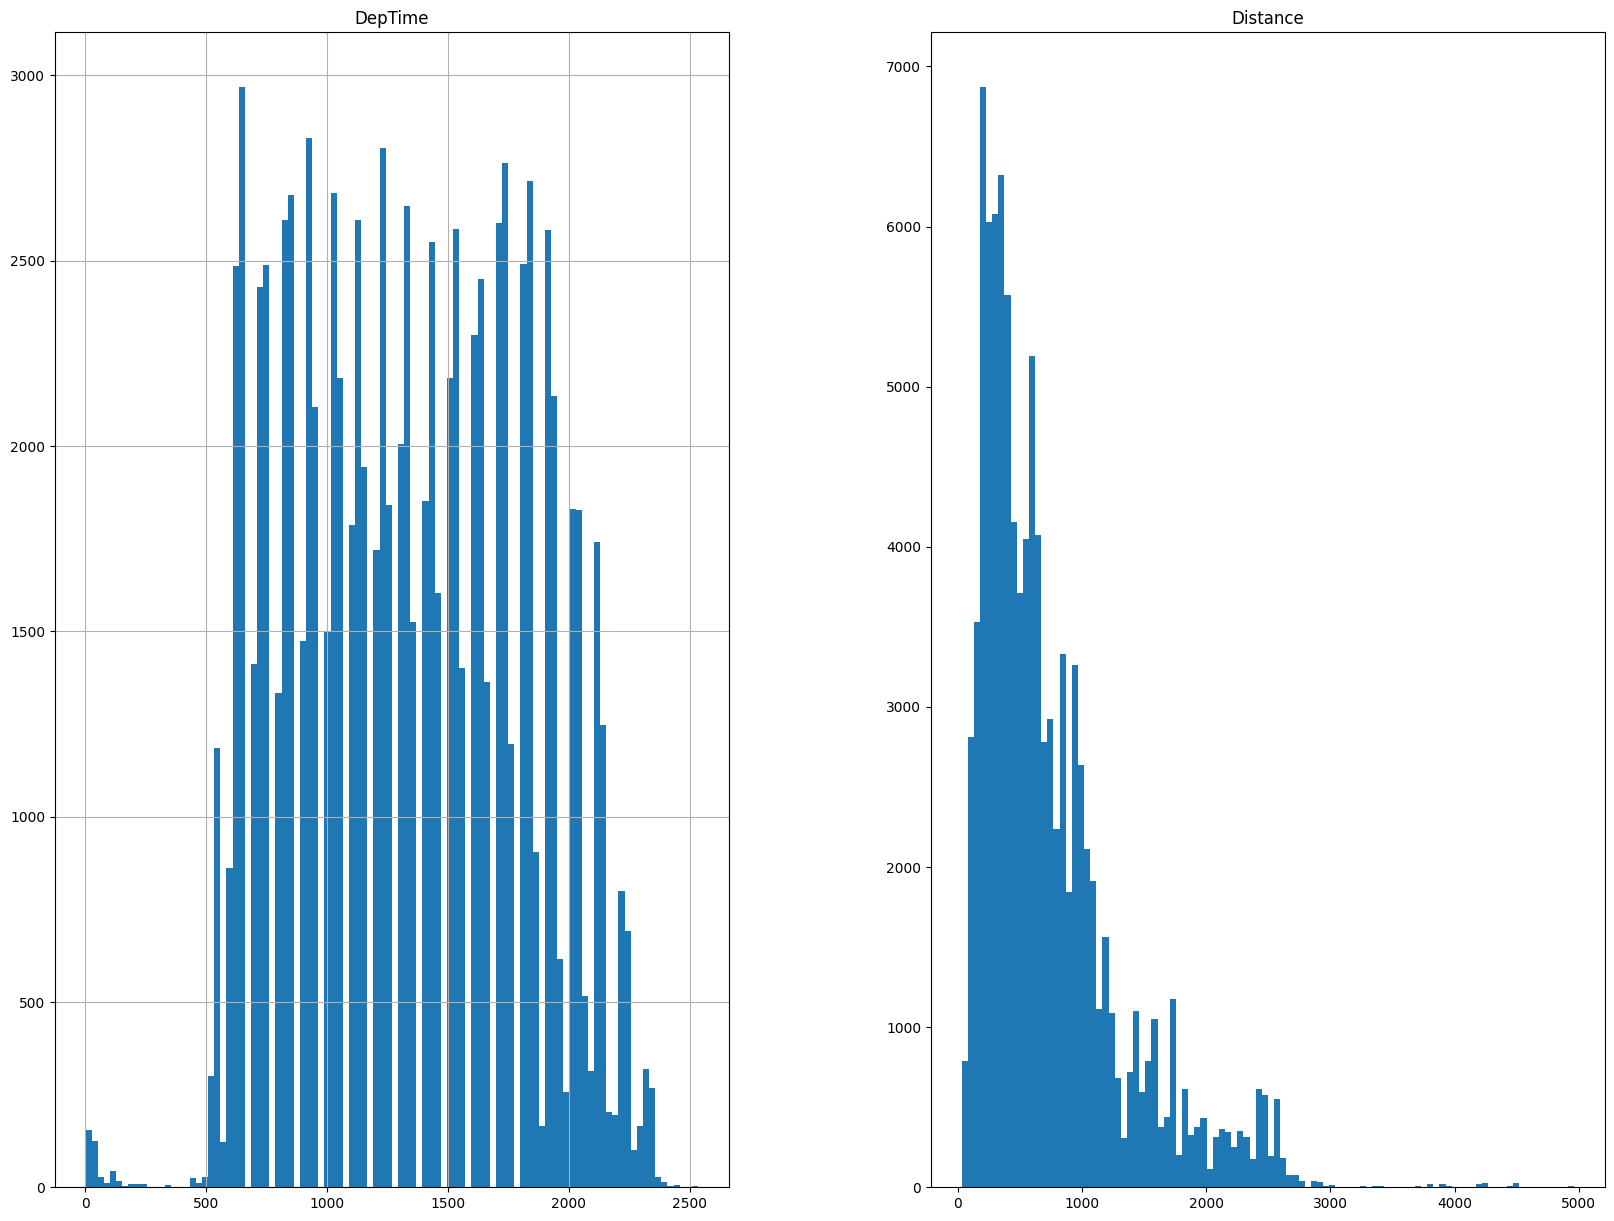

In [12]:
train.hist(bins=100, figsize=(20,15))
plt.grid()
plt.show()

### Label Encoder

In [13]:
train['UniqueCarrier'].value_counts()

UniqueCarrier
WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: count, dtype: int64

In [14]:
test['UniqueCarrier'].value_counts()

UniqueCarrier
WN    15876
AA     8606
OO     7953
MQ     6981
US     6587
DL     6496
UA     6435
XE     5836
NW     5602
CO     4367
YV     3901
EV     3770
FL     3500
9E     3461
OH     3103
B6     2651
AS     2134
F9     1390
HA      722
AQ      629
Name: count, dtype: int64

In [15]:
combined_unique_carrier = pd.concat([train['UniqueCarrier'], test['UniqueCarrier']], axis=0)

label_encoder = LabelEncoder()

label_encoder.fit(combined_unique_carrier)

train['UniqueCarrier_encoded'] = label_encoder.transform(train['UniqueCarrier'])
test['UniqueCarrier_encoded'] = label_encoder.transform(test['UniqueCarrier'])

print(train[['UniqueCarrier', 'UniqueCarrier_encoded']].head())
print(test[['UniqueCarrier', 'UniqueCarrier_encoded']].head())

  UniqueCarrier  UniqueCarrier_encoded
0            AA                      1
1            US                     19
2            XE                     21
3            OO                     16
4            WN                     20
  UniqueCarrier  UniqueCarrier_encoded
0            YV                     22
1            WN                     20
2            MQ                     13
3            WN                     20
4            UA                     18


In [16]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,1
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,19
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,21
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,16
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,20
...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N,16
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N,5
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N,14
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N,13


In [17]:
train['UniqueCarrier'].value_counts()

UniqueCarrier
WN    15082
AA     9418
DL     8128
MQ     7443
OO     7390
UA     6876
US     6482
NW     6403
XE     5901
OH     4594
CO     4334
EV     3930
FL     3039
AS     2222
YV     2128
B6     1838
HP     1378
F9     1006
DH      966
HA      762
TZ      446
AQ      234
Name: count, dtype: int64

In [18]:
train['UniqueCarrier_encoded'].value_counts()

UniqueCarrier_encoded
20    15082
1      9418
7      8128
13     7443
16     7390
18     6876
19     6482
14     6403
21     5901
15     4594
5      4334
8      3930
10     3039
3      2222
22     2128
4      1838
12     1378
9      1006
6       966
11      762
17      446
2       234
Name: count, dtype: int64

In [19]:
test['UniqueCarrier_encoded'].value_counts()

UniqueCarrier_encoded
20    15876
1      8606
16     7953
13     6981
19     6587
7      6496
18     6435
21     5836
14     5602
5      4367
22     3901
8      3770
10     3500
0      3461
15     3103
4      2651
3      2134
9      1390
11      722
2       629
Name: count, dtype: int64

In [20]:
test['UniqueCarrier'].value_counts()

UniqueCarrier
WN    15876
AA     8606
OO     7953
MQ     6981
US     6587
DL     6496
UA     6435
XE     5836
NW     5602
CO     4367
YV     3901
EV     3770
FL     3500
9E     3461
OH     3103
B6     2651
AS     2134
F9     1390
HA      722
AQ      629
Name: count, dtype: int64

## Data Processing

In [21]:
pd.set_option('future.no_silent_downcasting', True)

In [22]:
train['dep_delayed_15min'] = train['dep_delayed_15min'].replace({'N': 0, 'Y': 1})
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0,1
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0,19
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0,21
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0,16
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1,20
...,...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,0,16
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,0,5
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,0,14
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,0,13


In [23]:
train = transform_df(train)
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded,DepTime_hour,DepTime_minute
0,8,21,7,1934,AA,ATL,DFW,732,0,1,19,34
1,4,20,3,1548,US,PIT,MCO,834,0,19,15,48
2,9,2,5,1422,XE,RDU,CLE,416,0,21,14,22
3,11,25,6,1015,OO,DEN,MEM,872,0,16,10,15
4,10,7,6,1828,WN,MDW,OMA,423,1,20,18,28
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,16,18
99996,1,18,3,804,CO,EWR,DAB,884,0,5,8,4
99997,1,24,2,1901,NW,DTW,IAH,1076,0,14,19,1
99998,4,27,4,1515,MQ,DFW,GGG,140,0,13,15,15


In [24]:
test = transform_df(test)
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute
0,7,25,3,615,YV,MRY,PHX,598,22,6,15
1,4,17,2,739,WN,LAS,HOU,1235,20,7,39
2,12,2,7,651,MQ,GSP,ORD,577,13,6,51
3,3,25,7,1614,WN,BWI,MHT,377,20,16,14
4,6,6,3,1505,UA,ORD,STL,258,18,15,5
...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,20,8,52
99996,11,24,6,1446,UA,ORD,LAS,1515,18,14,46
99997,1,30,2,1509,OO,ORD,SGF,438,16,15,9
99998,1,5,5,804,DL,LGA,ATL,761,7,8,4


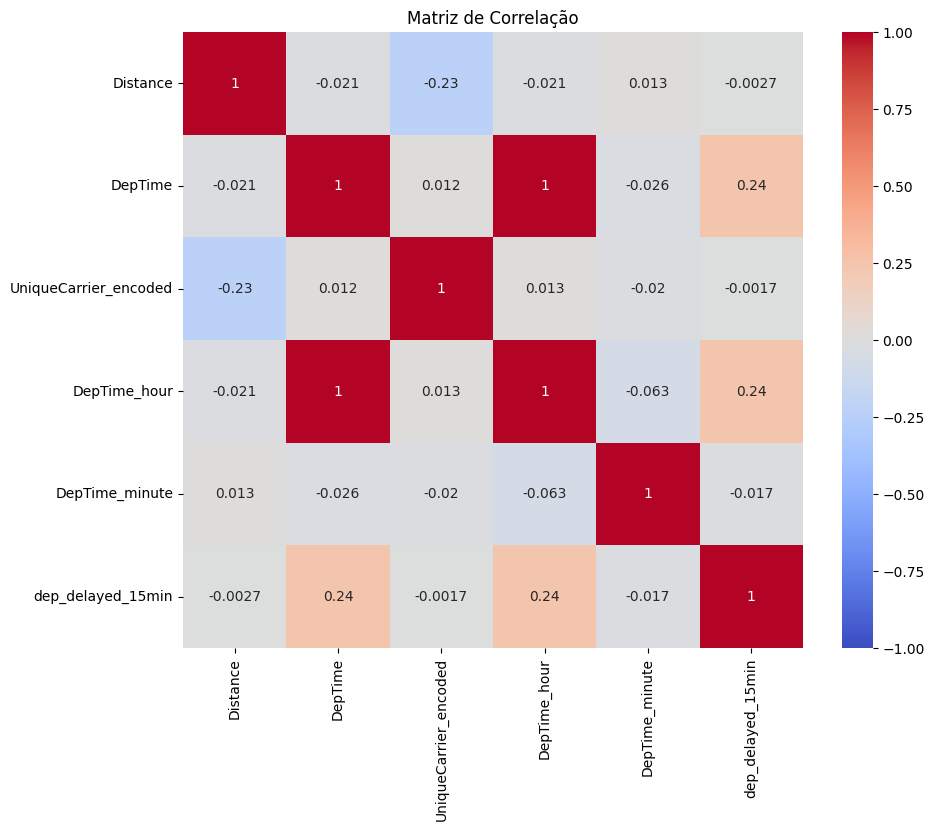

In [25]:
cols = ['Distance', 'DepTime', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'dep_delayed_15min']
df_corr = train[cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlação')
plt.show()

In [26]:
train['Route'] =  train['Origin'] + "_" + train['Dest']
test['Route'] =  test['Origin'] + "_" + test['Dest']

In [27]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route
0,8,21,7,1934,AA,ATL,DFW,732,0,1,19,34,ATL_DFW
1,4,20,3,1548,US,PIT,MCO,834,0,19,15,48,PIT_MCO
2,9,2,5,1422,XE,RDU,CLE,416,0,21,14,22,RDU_CLE
3,11,25,6,1015,OO,DEN,MEM,872,0,16,10,15,DEN_MEM
4,10,7,6,1828,WN,MDW,OMA,423,1,20,18,28,MDW_OMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,OO,SFO,RDD,199,0,16,16,18,SFO_RDD
99996,1,18,3,804,CO,EWR,DAB,884,0,5,8,4,EWR_DAB
99997,1,24,2,1901,NW,DTW,IAH,1076,0,14,19,1,DTW_IAH
99998,4,27,4,1515,MQ,DFW,GGG,140,0,13,15,15,DFW_GGG


In [28]:
test

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route
0,7,25,3,615,YV,MRY,PHX,598,22,6,15,MRY_PHX
1,4,17,2,739,WN,LAS,HOU,1235,20,7,39,LAS_HOU
2,12,2,7,651,MQ,GSP,ORD,577,13,6,51,GSP_ORD
3,3,25,7,1614,WN,BWI,MHT,377,20,16,14,BWI_MHT
4,6,6,3,1505,UA,ORD,STL,258,18,15,5,ORD_STL
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,WN,CRP,HOU,187,20,8,52,CRP_HOU
99996,11,24,6,1446,UA,ORD,LAS,1515,18,14,46,ORD_LAS
99997,1,30,2,1509,OO,ORD,SGF,438,16,15,9,ORD_SGF
99998,1,5,5,804,DL,LGA,ATL,761,7,8,4,LGA_ATL


## Experimentos

In [29]:
cols = ['dep_delayed_15min', 'UniqueCarrier', 'Origin', 'Dest']
X = train.drop(cols, axis=1)
X

,Month,DayofMonth,DayOfWeek,DepTime,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route
0,8,21,7,1934,732,1,19,34,ATL_DFW
1,4,20,3,1548,834,19,15,48,PIT_MCO
2,9,2,5,1422,416,21,14,22,RDU_CLE
3,11,25,6,1015,872,16,10,15,DEN_MEM
4,10,7,6,1828,423,20,18,28,MDW_OMA
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,199,16,16,18,SFO_RDD
99996,1,18,3,804,884,5,8,4,EWR_DAB
99997,1,24,2,1901,1076,14,19,1,DTW_IAH
99998,4,27,4,1515,140,13,15,15,DFW_GGG


In [30]:
y = train['dep_delayed_15min'].copy()
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: dep_delayed_15min, Length: 100000, dtype: object

In [31]:
cols = ['UniqueCarrier', 'Origin', 'Dest']
X_test = test.drop(cols, axis=1)
X_test

,Month,DayofMonth,DayOfWeek,DepTime,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route
0,7,25,3,615,598,22,6,15,MRY_PHX
1,4,17,2,739,1235,20,7,39,LAS_HOU
2,12,2,7,651,577,13,6,51,GSP_ORD
3,3,25,7,1614,377,20,16,14,BWI_MHT
4,6,6,3,1505,258,18,15,5,ORD_STL
...,...,...,...,...,...,...,...,...,...
99995,6,5,2,852,187,20,8,52,CRP_HOU
99996,11,24,6,1446,1515,18,14,46,ORD_LAS
99997,1,30,2,1509,438,16,15,9,ORD_SGF
99998,1,5,5,804,761,7,8,4,LGA_ATL


### CatBoost

In [43]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route']

### Sem Holdout

In [44]:
gb_model = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, random_state= 42)
gb_model.fit(X, y, cat_features=cat_features, use_best_model=True, verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.07361
0:	total: 62.7ms	remaining: 1m 2s
1:	total: 140ms	remaining: 1m 9s
2:	total: 195ms	remaining: 1m 4s
3:	total: 250ms	remaining: 1m 2s
4:	total: 312ms	remaining: 1m 2s
5:	total: 333ms	remaining: 55.1s
6:	total: 381ms	remaining: 54.1s
7:	total: 456ms	remaining: 56.6s
8:	total: 542ms	remaining: 59.7s
9:	total: 584ms	remaining: 57.8s
10:	total: 636ms	remaining: 57.2s
11:	total: 692ms	remaining: 57s
12:	total: 753ms	remaining: 57.2s
13:	total: 791ms	remaining: 55.7s
14:	total: 816ms	remaining: 53.6s
15:	total: 895ms	remaining: 55.1s
16:	total: 968ms	remaining: 56s
17:	total: 1.04s	remaining: 56.6s
18:	total: 1.12s	remaining: 58.1s
19:	total: 1.2s	remaining: 58.6s
20:	total: 1.24s	remaining: 57.7s
21:	total: 1.31s	remaining: 58.4s
22:	total: 1.38s	remaining: 58.7s
23:	total: 1.46s	remaining: 59.4s
24:	total: 1.53s	remaining: 59.7s
25:	total: 1.63s	remaining: 1m 1s
26:	total: 1.72s	remaining: 1m 2s
27:	total: 1.81s	remaining: 1m 2s
28:	total: 1.85s	remaining: 1m 1s

In [45]:
gb_test_pred = gb_model.predict_proba(X_test)[:, 1]
pd.Series(gb_test_pred, name='dep_delayed_15min').to_csv('rjhxa_gsg.csv', index_label='id', header=True)

> Resultado foi de 0.73289

### OUTRO TESTE

In [41]:
X

,Month,DayofMonth,DayOfWeek,DepTime,Distance,UniqueCarrier_encoded,DepTime_hour,DepTime_minute,Route
0,8,21,7,1934,732,1,19,34,ATL_DFW
1,4,20,3,1548,834,19,15,48,PIT_MCO
2,9,2,5,1422,416,21,14,22,RDU_CLE
3,11,25,6,1015,872,16,10,15,DEN_MEM
4,10,7,6,1828,423,20,18,28,MDW_OMA
...,...,...,...,...,...,...,...,...,...
99995,5,4,3,1618,199,16,16,18,SFO_RDD
99996,1,18,3,804,884,5,8,4,EWR_DAB
99997,1,24,2,1901,1076,14,19,1,DTW_IAH
99998,4,27,4,1515,140,13,15,15,DFW_GGG


In [42]:
y

0        0
1        0
2        0
3        0
4        1
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: dep_delayed_15min, Length: 100000, dtype: object

In [ ]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance', 'UniqueCarrier_encoded', 'DepTime_hour', 'DepTime_minute', 'Route']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.3, random_state=42)

In [ ]:
cb_grid = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=40)
cb_grid.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, use_best_model=True, verbose=True)

In [ ]:
pred = cb_grid.predict_proba(X_test)[:,1]
pd.Series(pred, 
          name='dep_delayed_15min').to_csv('catboost_default_params.csv', 
                                           index_label='id', 
                                           header=True)